In [1]:
import numpy as np
import pandas as pd
import torch

from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem, DataStructs

RDLogger.DisableLog('rdApp.*')

from collections import Counter
from itertools import product

import selfies as sf

import matplotlib.pyplot as plt
from matplotlib.colors import to_hex

from mpl_toolkits.mplot3d import Axes3D

import os

from tqdm import tqdm

/Users/jonghopark/miniconda3/envs/moses/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append("..")
import moses
from moses.vae import VAE
from moses.vae_property import VAEPROPERTY
from moses.utils import CharVocab, StringDataset, SELFIESVocab
from moses.vae.trainer import VAETrainer
from moses.vae_property.trainer import VAEPROPERTYTrainer

from moses.metrics import QED, SA, logP
from moses.utils import get_mol

# 1. Loading data

## 1.1 Loading model

In [3]:
folder_path = "../model_results/ZINC250K_vae_selfies"

if "property" in folder_path:
    config_path = "vae_property_config.pt"
    model_path = "vae_property_model.pt"
    vocab_path = "vae_property_vocab.pt"

else:
    config_path = "vae_config.pt"
    model_path = 'vae_model_060.pt'
    vocab_path = 'vae_vocab.pt'

config = torch.load(f"{folder_path}/{config_path}")

vocab = torch.load(f"{folder_path}/{vocab_path}")

if "property" in folder_path:
    model = VAEPROPERTY(vocab, config)
else:
    model = VAE(vocab, config)

model.load_state_dict(torch.load(f"{folder_path}/{model_path}"))

<All keys matched successfully>

## 1.2 Loading train data

In [4]:
data_folder_path = "../moses/dataset/data/ZINC250K"

file_name = "train.csv"

data = pd.read_csv(f"{data_folder_path}/{file_name}")

In [5]:
data.head() #it has smiles, selfies, logP, qed, SAS, obj values

,SMILES,SELFIES,logP,qed,SAS,obj
0,COCCOc1ccc(CNC(=O)c2cnc3ccc(C)cn23)cc1,[C][O][C][C][O][C][=C][C][=C][Branch2][Ring1][...,2.59792,0.672152,2.174005,1.186756
1,Cc1cc(C(=O)NC(C)(C)c2cccc(F)c2)[nH]n1,[C][C][C][=C][Branch2][Ring1][Branch2][C][=Bra...,2.52232,0.891576,2.577987,1.879891
2,CCc1n[nH]c(SCc2nnnn2-c2cc(C)ccc2F)n1,[C][C][C][=N][NH1][C][Branch2][Ring1][=Branch1...,2.08262,0.724791,2.787800,0.836156
3,COc1ccc(CC(=O)Nc2cccc3ncccc23)cc1,[C][O][C][=C][C][=C][Branch2][Ring1][Branch1][...,3.42460,0.801260,1.647545,2.358755
4,CCOc1ccc(Cl)c(C(=O)Nc2cc(C)nn2CCC#N)n1,[C][C][O][C][=C][C][=C][Branch1][C][Cl][C][Bra...,2.80460,0.876945,2.582261,1.802464


### 1.2.1 generate whole_latent_data

In [6]:
np.random.seed(42)
samples = data.iloc[np.random.choice(data.shape[0], 1000, replace=False)]

In [7]:
def get_latent_info(mol_smiles, model):
    mu, log_var, z, _ = model.forward_encoder(model.string2tensor(mol_smiles).reshape(1,-1))

    return mu, log_var, z

In [8]:
def get_latent_whole_info(data, model, use_selfies=False):
    mu_list = []
    log_var_list = []
    z_list = []

    if use_selfies:
        for i in range(len(data)):
            mu, log_var, z = get_latent_info(data["SELFIES"].iloc[i], model)
            mu_list.append(mu)
            log_var_list.append(log_var)
            z_list.append(z)
    else:
        for i in range(len(data)):
            mu, log_var, z = get_latent_info(data["SMILES"].iloc[i], model)
            mu_list.append(mu)
            log_var_list.append(log_var)
            z_list.append(z)
    

    mu_df = pd.DataFrame([[point.detach().cpu().numpy()]for point in mu_list], columns=["mu"], index=data.index)
    logvar_df = pd.DataFrame([[point.detach().cpu().numpy()]for point in log_var_list], columns=["logvar"], index=data.index)
    z_df = pd.DataFrame([[point.detach().cpu().numpy()]for point in z_list], columns=["z"], index=data.index)

    return mu_df, logvar_df, z_df

In [9]:
mu_df, log_var_df, z_df = get_latent_whole_info(samples, model, use_selfies = config.use_selfies)

In [10]:
whole_latent_info = pd.concat([samples, mu_df, log_var_df, z_df], axis=1)

In [11]:
whole_latent_info

,SMILES,SELFIES,logP,qed,SAS,obj,mu,logvar,z
38683,CC(C)n1nnnc1SCc1cc(F)cc2c1OCOC2,[C][C][Branch1][C][C][N][N][=N][N][=C][Ring1][...,2.55190,0.808834,2.786591,1.257578,"[[-6.8448484e-05, 0.0034608915, -0.00081660785...","[[-0.003979631, -0.0032232031, 0.002651371, -0...","[[1.0979425, 0.58445644, 1.4298434, 0.41916108..."
64939,O=C(CCO)N1CCC2(CC(Nc3ncccn3)CO2)C1,[O][=C][Branch1][Ring2][C][C][O][N][C][C][C][B...,0.03090,0.813958,4.044754,0.025037,"[[-0.0013073161, 0.0026925057, 0.0014745779, -...","[[-0.005001202, -0.0038585477, 0.00047388673, ...","[[0.3143564, -0.4609688, -0.65078884, -0.55082..."
3954,COc1c(CN(CCC#N)Cc2ccccn2)c(C)nn1C,[C][O][C][=C][Branch2][Ring1][C][C][N][Branch1...,2.04800,0.782484,2.591605,1.320817,"[[-0.00046313554, 0.0017014891, 0.0013142414, ...","[[-0.0037968904, -0.0030976236, 0.0029896796, ...","[[1.3314342, -1.6117488, 0.5896292, -0.2546068..."
120374,CC(C)CCn1c(=O)c2sccc2n2c(=O)[nH]nc12,[C][C][Branch1][C][C][C][C][N][C][=Branch1][C]...,1.44510,0.787737,2.793158,1.145527,"[[-0.0038493723, -0.0016093552, -6.638281e-05,...","[[-0.004235968, -0.0017666724, 0.0011616424, -...","[[1.4515381, -0.13646936, -1.3554575, -0.27786..."
172861,N#Cc1ccccc1N1CCN(C(=O)CCN2CCCCC2=O)CC1,[N][#C][C][=C][C][=C][C][=C][Ring1][=Branch1][...,1.60948,0.835036,2.200988,1.974191,"[[-0.0049827695, 0.0018333793, 0.0022754483, -...","[[-0.005468704, -0.0043663234, 0.0018786415, -...","[[-0.5210035, -1.3488808, -1.4310743, -0.11886..."
...,...,...,...,...,...,...,...,...,...
3963,CCOc1ccc(C2NC(=O)NC3=C2C(=O)N(CCC(C)C)C3)cc1,[C][C][O][C][=C][C][=C][Branch2][Ring1][=N][C]...,2.58160,0.833919,2.937811,1.231782,"[[0.0014974196, 0.009064019, -0.007574752, -0....","[[-0.0018871203, -0.0064359605, 0.0049115643, ...","[[-0.62007326, -0.25112593, 0.9754153, 1.29354..."
79890,Cc1cc(C)c(NC(=O)CNc2nc3ccccc3nc2C)c(C)c1,[C][C][=C][C][Branch1][C][C][=C][Branch2][Ring...,3.91408,0.758875,2.142944,1.651432,"[[0.0014700331, 0.005404085, -0.001747854, -0....","[[-0.005630061, -0.0035716444, 0.002090253, 0....","[[0.71065205, 1.0510722, -1.2777047, 0.632281,..."
15295,Cc1cccc(N2CC(C(=O)N3CCOC(C)C3)CC2=O)c1C,[C][C][=C][C][=C][C][Branch2][Ring1][#Branch2]...,1.90364,0.837225,2.955786,1.230338,"[[-0.0020108297, 0.0033032298, -0.0014532357, ...","[[-0.004667327, -0.0027611703, 0.005034171, 3....","[[-0.64844686, 0.82001764, -0.37277746, -0.670..."
218373,CN(Cc1cccnc1)S(=O)(=O)N1CCNCC1,[C][N][Branch1][#Branch2][C][C][=C][C][=C][N][...,-0.33660,0.812984,2.360259,1.704662,"[[-0.0064649954, 0.00051987916, 0.00747793, -0...","[[-0.0017607734, -0.0035702232, 0.00148689, -0...","[[-0.18409616, -0.4356131, 0.54339623, -0.1588..."


## 1.2.2 for test mol, generate molecular diagram

In [12]:
props = ["logP", "qed", "SAS", "obj"]

for idx, prop in enumerate(props):
    print(idx,prop)

0 logP
1 qed
2 SAS
3 obj


In [1]:
def sample_latent_space(mu, model, ranges=(3,3), latent_dim=128, n_trials=1000, 
                        n_grid=6, temp=0.01, orthogonal_vec=(None,None), save_name=None, prop_save_name=None,
                        props=None, use_selfies=False): #note : props should be list of properties among "logP", "qed", "SA", "obj

    np.random.seed(42)

    if orthogonal_vec[0] is None or orthogonal_vec[1] is None: # orthogonal vectors are not given -> set two basis vectors
        orthogonal_vec = np.eye(latent_dim)[np.random.randint(0, latent_dim, 2)]

    x_range, y_range = ranges

    dx = np.linspace(-x_range, x_range, 2*n_grid+1)
    dy = np.linspace(-y_range, y_range, 2*n_grid+1)

    grid = pd.DataFrame(columns=range(2*n_grid+1), index=range(2*n_grid+1))

    prop_grid_list = []

    for _ in range(len(props)):
        prop_grid_list.append(pd.DataFrame(columns=range(2*n_grid+1), index=range(2*n_grid+1)))

    for i_x, i_y in tqdm(product(range(2*n_grid+1), range(2*n_grid+1)), total=(2*n_grid+1)**2,desc='whole_iters'): #each data points
        z_point = mu + dx[i_x]*orthogonal_vec[0] + dy[i_y]*orthogonal_vec[1] # move the point to the direction of the unit vector
        most_freq_mol, freq_df = decode_z(z_point, model, n_trials, temp, use_selfies=use_selfies)

        grid.iloc[i_x, i_y] = most_freq_mol

        for idx, prop in enumerate(props):
            prop_grid_list[idx].iloc[i_x, i_y] = calc_avg_prop(freq_df, props=prop)
                    
    if save_name is not None:
        grid.to_csv(save_name)
    
    if prop_save_name is not None:
        for idx, prop in enumerate(props):
            prop_grid_list[idx].to_csv(f"{prop_save_name}_{prop}.csv")
    
    return grid

def decode_z(z, model, n_trials, temp, use_selfies):
    # decode n_trials times from z using the model sample function, and pick most frequent one
    z_input = torch.tensor(z).repeat(n_trials).reshape(n_trials, -1)

    z_input = z_input.float()

    decoded_mols = model.sample(n_batch=z_input.shape[0], z=z_input, temp=temp)

    if use_selfies:
        decoded_mols = [sf.decoder(mol) for mol in decoded_mols]
        
    valid_decoded_mols = [Chem.MolFromSmiles(mol) for mol in decoded_mols if Chem.MolFromSmiles(mol) is not None]
    
    print(f"ratio of valid molecules : {len(valid_decoded_mols)}/{n_trials}")

    canon_dec_mols = [Chem.MolToSmiles(Chem.MolFromSmiles(mol), canonical=True) for mol in decoded_mols if Chem.MolFromSmiles(mol) is not None]

    mol_freq = Counter(canon_dec_mols)

    most_freq_mol, _ = find_argmax(mol_freq)

    freq_df = get_mol_freq(mol_freq)

    return most_freq_mol, freq_df

def find_argmax(counter):
    # Get the most common element and its count
    most_common_element = counter.most_common(1)
    if most_common_element:
        element, count = most_common_element[0]
        return element, count
    else:
        return None, None

def get_mol_freq(counter):
    # Get the most common element and its count
    mols = counter.keys()
    counts = counter.values()

    freq_df = pd.DataFrame({"mols":mols, "counts":counts})

    return freq_df

def calc_avg_prop(freq_df, props=None):
    if props is None:
        return None
    
    mols = freq_df["mols"] # smiles
    counts = freq_df["counts"]

    avg_prop = 0
    total_count = 0

    for mol, count in zip(mols, counts):
        prop = get_mol_prop(mol, props) # if mol is invalid, skip that molecule and exclude from the calculation of average property.

        if prop is not None:
            total_count += count
            avg_prop += prop*count

    if total_count == 0:
        return None

    else:
        avg_prop /= total_count
        return avg_prop

def get_mol_prop(mol, props): # get the property of the molecule
    chemmol = Chem.MolFromSmiles(mol)

    if chemmol is None:
        return None

    if props == "logP":
        return logP(chemmol)
    elif props == "qed":
        return QED(chemmol)
    elif props == "SA":
        return SA(chemmol)
    elif props == 'obj':
        return 5 * QED(chemmol) - SA(chemmol)
    else:
        return None
    
def plot_freq_mols_with_color(freq_mols_grid_df, save_name=None):
    # plot grid-wise latent space for each molecules
    # and return the color dictionary for each molecule
    
    n_rows, n_cols = freq_mols_grid_df.shape

    mol_positions = {}

    # 그리드의 각 칸에 대해 분자를 추적합니다.
    for i in range(n_rows):
        for j in range(n_cols):
            if freq_mols_grid_df.iloc[i,j] is None: # if the cell is invalid 
                if "Invalid" not in mol_positions:
                    mol_positions["Invalid"] = []
                mol_positions["Invalid"].append((i,j))

            mol = freq_mols_grid_df.iloc[i, j]
            if mol:  # 빈 셀을 무시합니다.
                mol_smiles = str(mol)
                if mol_smiles not in mol_positions:
                    mol_positions[mol_smiles] = []
                mol_positions[mol_smiles].append((i, j))  # 분자가 존재하는 칸의 위치를 저장합니다.

    # 분자별로 고유한 색을 할당합니다, 단 색상은 중심에 위치한 분자로부터의 tanimoto similarity로 정의됩니다.
    central_mol = freq_mols_grid_df.iloc[n_rows // 2, n_cols // 2]

    unique_colors = {mol_smiles: tuple([1-calculate_tanomoto_similiarity(mol_smiles, central_mol)]*3) for mol_smiles in mol_positions.keys() if mol_smiles != "Invalid"}
    unique_colors['Invalid'] = (1,1,1) # invalid molecules are colored white

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(10,10))
    for i in range(n_rows):
        for j in range(n_cols):
            # print(freq_mols_grid_df.iloc[i,j]=='nan', type(freq_mols_grid_df.iloc[i,j]))
            if freq_mols_grid_df.iloc[i,j] is None:
                color = unique_colors["Invalid"]        
                mol = None
            else:
                color = unique_colors[freq_mols_grid_df.iloc[i,j]]
                mol = Chem.MolFromSmiles(freq_mols_grid_df.iloc[i,j])

            if mol is not None:
                ax[i,j].add_patch(plt.Rectangle((0,0), 1,1, color=color))
                ax[i,j].axis("off")
            else:
                ax[i,j].axis("off")
    
    if save_name is not None:
        plt.savefig(save_name, dpi=300)

    plt.show()
    plt.clf() 
    
    return unique_colors

def calculate_tanomoto_similiarity(mol1, mol2):
    
    if mol1 is None:
        return 0
    
    fp1 = AllChem.GetMorganFingerprint(Chem.MolFromSmiles(mol1), 2)
    fp2 = AllChem.GetMorganFingerprint(Chem.MolFromSmiles(mol2), 2)
    return DataStructs.TanimotoSimilarity(fp1, fp2)


def plot_freq_mols(freq_mols_grid_info, save_name=None):
    if type(freq_mols_grid_info) is str:
        plot_freq_mols_from_path(freq_mols_grid_info, save_name)
    elif type(freq_mols_grid_info) is pd.DataFrame:
        plot_freq_mols_from_df(freq_mols_grid_info, save_name)
    else:
        raise ValueError("Invalid input type")

def plot_freq_mols_from_path(freq_grid_path, save_name=None):
    freq_mols_grid = pd.read_csv(freq_grid_path, index_col=0)

    plot_freq_mols_from_df(freq_mols_grid, save_name)

def plot_freq_mols_from_df(freq_mols_grid, save_name=None):
    n_rows, n_cols = freq_mols_grid.shape

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(10,10))

    for i in range(n_rows):
        for j in range(n_cols):
            if freq_mols_grid.iloc[i,j] is None:
                ax[i,j].axis("off")
                continue

            mol = Chem.MolFromSmiles(freq_mols_grid.iloc[i,j])
            
            if mol is not None:
                img = Chem.Draw.MolToImage(mol, size=(300,300))
                ax[i,j].imshow(img)
                ax[i,j].axis("off")
            else:
                ax[i,j].axis("off")

    if save_name is not None:
        plt.savefig(save_name, dpi=300)
        plt.clf()

def plot_prop_mols(prop_grid_info, save_name=None, prop_name=None):
    if type(prop_grid_info) is str:
        plot_prop_mols_from_path(prop_grid_info, save_name, prop_name)
    elif type(prop_grid_info) is pd.DataFrame:
        plot_prop_mols_from_df(prop_grid_info, save_name, prop_name)
    else:
        raise ValueError("Invalid input type")
    
def plot_prop_mols_from_path(prop_grid_path, save_name=None, prop_name=None):
    prop_grid = pd.read_csv(prop_grid_path, index_col=0)

    plot_prop_mols_from_df(prop_grid, save_name, prop_name)
    
def plot_prop_mols_from_df(prop_df, save_name=None, prop_name=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x = prop_df.index
    y = np.arange(len(prop_df.columns))

    X,Y = np.meshgrid(x,y)

    Z = prop_df.values

    print(prop_df)
    print(x)
    print(y)
    print(Z)

    surf = ax.plot_surface(X, Y, Z, cmap='viridis')

    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)


    ax.set_title("property surface in subspace of latent space")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel(prop_name)

    if save_name is not None:
        plt.savefig(save_name, dpi=300)
        plt.clf()

In [14]:
test_mol = whole_latent_info.iloc[0]

In [15]:
test_mol

SMILES                       CC(C)n1nnnc1SCc1cc(F)cc2c1OCOC2
SELFIES    [C][C][Branch1][C][C][N][N][=N][N][=C][Ring1][...
logP                                                  2.5519
qed                                                 0.808834
SAS                                                 2.786591
obj                                                 1.257578
mu         [[-6.8448484e-05, 0.0034608915, -0.00081660785...
logvar     [[-0.003979631, -0.0032232031, 0.002651371, -0...
z          [[1.0979425, 0.58445644, 1.4298434, 0.41916108...
Name: 38683, dtype: object

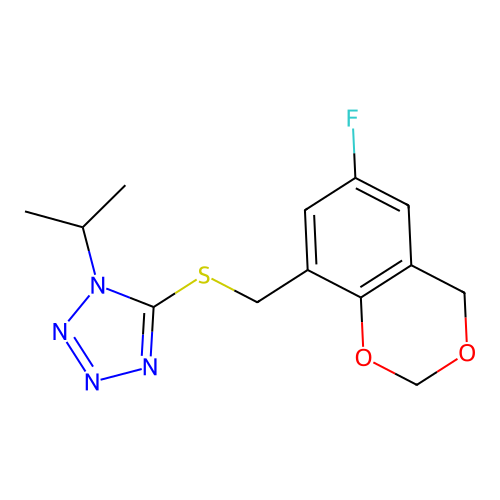

In [16]:
img = Chem.Draw.MolToImage(Chem.MolFromSmiles(test_mol['SMILES']), size=(500,500))


img

'../model_results/ZINC250K_vae_selfies'

In [19]:
ranges_list = [(10,10), (20,20), (30,30)]

temp_list = [0.01, 0.1, 1]

experiments = list(product(ranges_list, temp_list))

v1 = np.ones(config.d_z)
v1 = v1/np.linalg.norm(v1) # 1/sqrt(128)*np.ones(128)

v2 = np.array([1 if i < config.d_z//2 else -1 for i in range(config.d_z)])
v2 = v2/np.linalg.norm(v2) # 1/sqrt(128)*[1,1,1,1,1...,-1(65th coord),-1,-1,-1,-1... -1]

if config.use_selfies and "property" in folder_path:
    save_folder_path = f"figures/VAEprop_selfies/two_other_orthogonal_basis"
elif config.use_selfies:
    save_folder_path = f"figures/VAE_selfies/two_other_orthogonal_basis"
elif "property" in folder_path: #since smiles vae config doesn't have reg_prop_tasks
    save_folder_path = f"figures/VAEprop_smiles/two_other_orthogonal_basis"
else:
    save_folder_path = f"figures/VAE_smiles/two_other_orthogonal_basis"

prop_fname = "test_mol_prop"
mol_fname = "test_mol"

In [20]:
folder_path

'../model_results/ZINC250K_vae_selfies'

In [21]:
# generate path for each experiment

folder_list = [f"{save_folder_path}/{folder_name}" for folder_name in ['csv_folder', 'mol_plot', 'prop_plot', "color_plot"]]

for folder in folder_list:
    if not os.path.exists(folder):
        os.makedirs(folder, exist_ok=True)

In [30]:
for i, (ranges, temp) in enumerate(experiments):
    print(f"------------- Experiment {i} -------------")

    if i<=1:
        continue
    
    grid = sample_latent_space(test_mol["mu"][0], model, ranges=ranges, temp=temp, n_trials=100, n_grid=10, orthogonal_vec=(v1,v2),
                               prop_save_name=f"{save_folder_path}/csv_folder/{prop_fname}_{i}.csv", props=["logP", "SA", "qed", "obj"],
                               save_name=f"{save_folder_path}/csv_folder/{mol_fname}_{i}.csv", use_selfies=config.use_selfies)
    
    plot_freq_mols(grid, save_name=f"{save_folder_path}/mol_plot/{mol_fname}_{i}.png")

    for prop in ["logP", "SA", "qed", "obj"]:
        plot_prop_mols(prop_grid_info=f"{save_folder_path}/csv_folder/{prop_fname}_{i}.csv_{prop}.csv", save_name=f"{save_folder_path}/prop_plot/{prop_fname}_{i}_{prop}.png")

------------- Experiment 0 -------------
------------- Experiment 1 -------------
------------- Experiment 2 -------------


whole_iters:   0%|          | 0/441 [00:00<?, ?it/s]

ratio of valid molecules : 100/100
100
100
100


whole_iters:   0%|          | 1/441 [00:00<06:46,  1.08it/s]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   0%|          | 2/441 [00:01<06:47,  1.08it/s]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   1%|          | 3/441 [00:02<06:52,  1.06it/s]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   1%|          | 4/441 [00:03<07:10,  1.01it/s]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   1%|          | 5/441 [00:04<07:13,  1.01it/s]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   1%|▏         | 6/441 [00:05<07:05,  1.02it/s]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   2%|▏         | 7/441 [00:06<07:06,  1.02it/s]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   2%|▏         | 8/441 [00:07<07:10,  1.01it/s]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   2%|▏         | 9/441 [00:08<07:13,  1.00s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   2%|▏         | 10/441 [00:09<07:14,  1.01s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   2%|▏         | 11/441 [00:10<07:11,  1.00s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   3%|▎         | 12/441 [00:11<07:12,  1.01s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   3%|▎         | 13/441 [00:12<07:12,  1.01s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   3%|▎         | 14/441 [00:13<07:15,  1.02s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   3%|▎         | 15/441 [00:14<07:14,  1.02s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   4%|▎         | 16/441 [00:16<07:29,  1.06s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   4%|▍         | 17/441 [00:17<07:31,  1.07s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   4%|▍         | 18/441 [00:18<07:30,  1.07s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   4%|▍         | 19/441 [00:19<07:34,  1.08s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   5%|▍         | 20/441 [00:20<07:33,  1.08s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   5%|▍         | 21/441 [00:21<07:31,  1.08s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   5%|▍         | 22/441 [00:22<07:07,  1.02s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   5%|▌         | 23/441 [00:23<06:49,  1.02it/s]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   5%|▌         | 24/441 [00:24<06:44,  1.03it/s]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   6%|▌         | 25/441 [00:25<07:00,  1.01s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   6%|▌         | 26/441 [00:26<06:49,  1.01it/s]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   6%|▌         | 27/441 [00:27<06:45,  1.02it/s]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   6%|▋         | 28/441 [00:28<06:42,  1.03it/s]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   7%|▋         | 29/441 [00:29<06:40,  1.03it/s]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   7%|▋         | 30/441 [00:30<07:00,  1.02s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   7%|▋         | 31/441 [00:31<06:59,  1.02s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   7%|▋         | 32/441 [00:32<07:03,  1.04s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   7%|▋         | 33/441 [00:33<07:03,  1.04s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   8%|▊         | 34/441 [00:34<07:01,  1.04s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   8%|▊         | 35/441 [00:35<06:58,  1.03s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   8%|▊         | 36/441 [00:36<06:57,  1.03s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   8%|▊         | 37/441 [00:37<06:59,  1.04s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   9%|▊         | 38/441 [00:38<07:00,  1.04s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   9%|▉         | 39/441 [00:39<07:08,  1.07s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   9%|▉         | 40/441 [00:40<07:13,  1.08s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:   9%|▉         | 41/441 [00:41<07:16,  1.09s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  10%|▉         | 42/441 [00:43<07:15,  1.09s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  10%|▉         | 43/441 [00:43<06:51,  1.03s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  10%|▉         | 44/441 [00:44<06:41,  1.01s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  10%|█         | 45/441 [00:45<06:30,  1.01it/s]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  10%|█         | 46/441 [00:46<06:40,  1.01s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  11%|█         | 47/441 [00:47<06:35,  1.00s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  11%|█         | 48/441 [00:48<06:33,  1.00s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  11%|█         | 49/441 [00:49<06:34,  1.01s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  11%|█▏        | 50/441 [00:50<06:32,  1.00s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  12%|█▏        | 51/441 [00:51<06:32,  1.01s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  12%|█▏        | 52/441 [00:52<06:36,  1.02s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  12%|█▏        | 53/441 [00:54<06:38,  1.03s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  12%|█▏        | 54/441 [00:55<06:40,  1.03s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  12%|█▏        | 55/441 [00:56<06:37,  1.03s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  13%|█▎        | 56/441 [00:57<06:40,  1.04s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  13%|█▎        | 57/441 [00:58<06:44,  1.05s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  13%|█▎        | 58/441 [00:59<06:41,  1.05s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  13%|█▎        | 59/441 [01:00<06:44,  1.06s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  14%|█▎        | 60/441 [01:01<06:59,  1.10s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  14%|█▍        | 61/441 [01:02<06:56,  1.10s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  14%|█▍        | 62/441 [01:03<07:02,  1.12s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  14%|█▍        | 63/441 [01:04<07:04,  1.12s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  15%|█▍        | 64/441 [01:05<06:44,  1.07s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  15%|█▍        | 65/441 [01:06<06:30,  1.04s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  15%|█▍        | 66/441 [01:07<06:28,  1.04s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  15%|█▌        | 67/441 [01:08<06:15,  1.00s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  15%|█▌        | 68/441 [01:09<06:13,  1.00s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  16%|█▌        | 69/441 [01:10<06:13,  1.00s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  16%|█▌        | 70/441 [01:11<06:14,  1.01s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  16%|█▌        | 71/441 [01:12<06:13,  1.01s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  16%|█▋        | 72/441 [01:13<06:17,  1.02s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  17%|█▋        | 73/441 [01:14<06:18,  1.03s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  17%|█▋        | 74/441 [01:16<06:20,  1.04s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  17%|█▋        | 75/441 [01:17<06:17,  1.03s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  17%|█▋        | 76/441 [01:18<06:21,  1.05s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  17%|█▋        | 77/441 [01:19<06:30,  1.07s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  18%|█▊        | 78/441 [01:20<06:45,  1.12s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  18%|█▊        | 79/441 [01:21<06:38,  1.10s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  18%|█▊        | 80/441 [01:22<06:31,  1.08s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  18%|█▊        | 81/441 [01:23<06:32,  1.09s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  19%|█▊        | 82/441 [01:24<06:35,  1.10s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  19%|█▉        | 83/441 [01:25<06:40,  1.12s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  19%|█▉        | 84/441 [01:27<06:44,  1.13s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  19%|█▉        | 85/441 [01:28<06:22,  1.07s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  20%|█▉        | 86/441 [01:29<06:12,  1.05s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  20%|█▉        | 87/441 [01:30<05:58,  1.01s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  20%|█▉        | 88/441 [01:30<05:49,  1.01it/s]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  20%|██        | 89/441 [01:31<05:43,  1.03it/s]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  20%|██        | 90/441 [01:32<05:40,  1.03it/s]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  21%|██        | 91/441 [01:33<05:44,  1.02it/s]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  21%|██        | 92/441 [01:34<05:45,  1.01it/s]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  21%|██        | 93/441 [01:35<05:44,  1.01it/s]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  21%|██▏       | 94/441 [01:36<05:44,  1.01it/s]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  22%|██▏       | 95/441 [01:37<05:46,  1.00s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  22%|██▏       | 96/441 [01:39<06:00,  1.05s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  22%|██▏       | 97/441 [01:40<06:03,  1.06s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  22%|██▏       | 98/441 [01:41<06:09,  1.08s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  22%|██▏       | 99/441 [01:42<06:08,  1.08s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  23%|██▎       | 100/441 [01:43<06:07,  1.08s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  23%|██▎       | 101/441 [01:44<06:11,  1.09s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  23%|██▎       | 102/441 [01:45<06:18,  1.12s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  23%|██▎       | 103/441 [01:46<06:26,  1.14s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  24%|██▎       | 104/441 [01:48<06:27,  1.15s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  24%|██▍       | 105/441 [01:49<06:31,  1.16s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  24%|██▍       | 106/441 [01:50<06:08,  1.10s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  24%|██▍       | 107/441 [01:51<05:56,  1.07s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  24%|██▍       | 108/441 [01:52<05:45,  1.04s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  25%|██▍       | 109/441 [01:53<05:42,  1.03s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  25%|██▍       | 110/441 [01:54<05:42,  1.04s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  25%|██▌       | 111/441 [01:55<05:41,  1.04s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  25%|██▌       | 112/441 [01:56<05:43,  1.04s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  26%|██▌       | 113/441 [01:57<05:46,  1.06s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  26%|██▌       | 114/441 [01:58<05:45,  1.06s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  26%|██▌       | 115/441 [01:59<05:46,  1.06s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  26%|██▋       | 116/441 [02:00<05:48,  1.07s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  27%|██▋       | 117/441 [02:01<05:45,  1.07s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  27%|██▋       | 118/441 [02:02<05:50,  1.08s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  27%|██▋       | 119/441 [02:03<05:52,  1.09s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  27%|██▋       | 120/441 [02:05<05:50,  1.09s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  27%|██▋       | 121/441 [02:06<05:48,  1.09s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  28%|██▊       | 122/441 [02:07<06:03,  1.14s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  28%|██▊       | 123/441 [02:08<06:05,  1.15s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  28%|██▊       | 124/441 [02:09<06:00,  1.14s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  28%|██▊       | 125/441 [02:10<06:04,  1.15s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  29%|██▊       | 126/441 [02:12<06:09,  1.17s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  29%|██▉       | 127/441 [02:13<05:57,  1.14s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  29%|██▉       | 128/441 [02:14<05:41,  1.09s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  29%|██▉       | 129/441 [02:15<05:29,  1.06s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  29%|██▉       | 130/441 [02:16<05:37,  1.08s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  30%|██▉       | 131/441 [02:17<05:27,  1.06s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  30%|██▉       | 132/441 [02:18<05:20,  1.04s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  30%|███       | 133/441 [02:19<05:20,  1.04s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  30%|███       | 134/441 [02:20<05:20,  1.04s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  31%|███       | 135/441 [02:21<05:21,  1.05s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  31%|███       | 136/441 [02:22<05:22,  1.06s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  31%|███       | 137/441 [02:23<05:22,  1.06s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  31%|███▏      | 138/441 [02:24<05:28,  1.09s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  32%|███▏      | 139/441 [02:25<05:36,  1.11s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  32%|███▏      | 140/441 [02:26<05:31,  1.10s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  32%|███▏      | 141/441 [02:28<05:32,  1.11s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  32%|███▏      | 142/441 [02:29<05:34,  1.12s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  32%|███▏      | 143/441 [02:30<05:36,  1.13s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  33%|███▎      | 144/441 [02:31<05:34,  1.12s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  33%|███▎      | 145/441 [02:32<05:32,  1.12s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  33%|███▎      | 146/441 [02:33<05:32,  1.13s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  33%|███▎      | 147/441 [02:34<05:33,  1.14s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  34%|███▎      | 148/441 [02:35<05:16,  1.08s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  34%|███▍      | 149/441 [02:36<05:03,  1.04s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  34%|███▍      | 150/441 [02:37<04:55,  1.01s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  34%|███▍      | 151/441 [02:38<04:51,  1.01s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  34%|███▍      | 152/441 [02:39<04:49,  1.00s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  35%|███▍      | 153/441 [02:40<04:45,  1.01it/s]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  35%|███▍      | 154/441 [02:41<04:44,  1.01it/s]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  35%|███▌      | 155/441 [02:42<04:46,  1.00s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  35%|███▌      | 156/441 [02:43<04:51,  1.02s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  36%|███▌      | 157/441 [02:44<04:57,  1.05s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  36%|███▌      | 158/441 [02:45<05:00,  1.06s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  36%|███▌      | 159/441 [02:47<05:01,  1.07s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  36%|███▋      | 160/441 [02:48<05:04,  1.09s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  37%|███▋      | 161/441 [02:49<05:03,  1.08s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  37%|███▋      | 162/441 [02:50<05:02,  1.08s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  37%|███▋      | 163/441 [02:51<05:03,  1.09s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  37%|███▋      | 164/441 [02:52<05:06,  1.11s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  37%|███▋      | 165/441 [02:53<05:10,  1.13s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  38%|███▊      | 166/441 [02:54<05:18,  1.16s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  38%|███▊      | 167/441 [02:56<05:20,  1.17s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  38%|███▊      | 168/441 [02:57<05:15,  1.15s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  38%|███▊      | 169/441 [02:58<05:02,  1.11s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  39%|███▊      | 170/441 [02:59<04:53,  1.08s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  39%|███▉      | 171/441 [03:00<04:42,  1.05s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  39%|███▉      | 172/441 [03:01<04:37,  1.03s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  39%|███▉      | 173/441 [03:02<04:34,  1.02s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  39%|███▉      | 174/441 [03:03<04:34,  1.03s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  40%|███▉      | 175/441 [03:04<04:33,  1.03s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  40%|███▉      | 176/441 [03:05<04:33,  1.03s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  40%|████      | 177/441 [03:06<04:33,  1.04s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  40%|████      | 178/441 [03:07<04:36,  1.05s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  41%|████      | 179/441 [03:08<04:40,  1.07s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  41%|████      | 180/441 [03:09<04:38,  1.07s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  41%|████      | 181/441 [03:10<04:38,  1.07s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  41%|████▏     | 182/441 [03:11<04:44,  1.10s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  41%|████▏     | 183/441 [03:13<04:48,  1.12s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  42%|████▏     | 184/441 [03:14<04:51,  1.13s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  42%|████▏     | 185/441 [03:15<04:51,  1.14s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  42%|████▏     | 186/441 [03:16<04:54,  1.15s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  42%|████▏     | 187/441 [03:17<04:57,  1.17s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  43%|████▎     | 188/441 [03:19<04:59,  1.18s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  43%|████▎     | 189/441 [03:20<04:59,  1.19s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  43%|████▎     | 190/441 [03:21<04:42,  1.13s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  43%|████▎     | 191/441 [03:22<04:33,  1.09s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  44%|████▎     | 192/441 [03:23<04:26,  1.07s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  44%|████▍     | 193/441 [03:24<04:24,  1.07s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  44%|████▍     | 194/441 [03:25<04:20,  1.05s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  44%|████▍     | 195/441 [03:26<04:19,  1.06s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  44%|████▍     | 196/441 [03:27<04:18,  1.05s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  45%|████▍     | 197/441 [03:28<04:16,  1.05s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  45%|████▍     | 198/441 [03:29<04:16,  1.06s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  45%|████▌     | 199/441 [03:30<04:16,  1.06s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  45%|████▌     | 200/441 [03:31<04:17,  1.07s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  46%|████▌     | 201/441 [03:32<04:19,  1.08s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  46%|████▌     | 202/441 [03:33<04:22,  1.10s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  46%|████▌     | 203/441 [03:35<04:24,  1.11s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  46%|████▋     | 204/441 [03:36<04:27,  1.13s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  46%|████▋     | 205/441 [03:37<04:29,  1.14s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  47%|████▋     | 206/441 [03:38<04:25,  1.13s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  47%|████▋     | 207/441 [03:39<04:31,  1.16s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  47%|████▋     | 208/441 [03:40<04:29,  1.16s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  47%|████▋     | 209/441 [03:42<04:31,  1.17s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  48%|████▊     | 210/441 [03:43<04:34,  1.19s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  48%|████▊     | 211/441 [03:44<04:21,  1.14s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  48%|████▊     | 212/441 [03:45<04:16,  1.12s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  48%|████▊     | 213/441 [03:46<04:06,  1.08s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  49%|████▊     | 214/441 [03:47<04:01,  1.06s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  49%|████▉     | 215/441 [03:48<04:09,  1.11s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  49%|████▉     | 216/441 [03:49<04:06,  1.10s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  49%|████▉     | 217/441 [03:50<04:04,  1.09s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  49%|████▉     | 218/441 [03:52<04:16,  1.15s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  50%|████▉     | 219/441 [03:53<04:13,  1.14s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  50%|████▉     | 220/441 [03:54<04:12,  1.14s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  50%|█████     | 221/441 [03:55<04:12,  1.15s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  50%|█████     | 222/441 [03:56<04:12,  1.15s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  51%|█████     | 223/441 [03:57<04:10,  1.15s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  51%|█████     | 224/441 [03:59<04:12,  1.16s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  51%|█████     | 225/441 [04:00<04:13,  1.17s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  51%|█████     | 226/441 [04:01<04:13,  1.18s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  51%|█████▏    | 227/441 [04:02<04:12,  1.18s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  52%|█████▏    | 228/441 [04:03<04:10,  1.18s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  52%|█████▏    | 229/441 [04:04<04:10,  1.18s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  52%|█████▏    | 230/441 [04:06<04:06,  1.17s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  52%|█████▏    | 231/441 [04:07<04:06,  1.17s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  53%|█████▎    | 232/441 [04:08<03:59,  1.15s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  53%|█████▎    | 233/441 [04:09<03:49,  1.10s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  53%|█████▎    | 234/441 [04:10<03:43,  1.08s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  53%|█████▎    | 235/441 [04:11<03:39,  1.07s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  54%|█████▎    | 236/441 [04:12<03:37,  1.06s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  54%|█████▎    | 237/441 [04:13<03:34,  1.05s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  54%|█████▍    | 238/441 [04:14<03:38,  1.08s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  54%|█████▍    | 239/441 [04:15<03:37,  1.08s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  54%|█████▍    | 240/441 [04:16<03:36,  1.07s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  55%|█████▍    | 241/441 [04:17<03:35,  1.08s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  55%|█████▍    | 242/441 [04:19<03:41,  1.11s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  55%|█████▌    | 243/441 [04:20<03:40,  1.11s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  55%|█████▌    | 244/441 [04:21<03:40,  1.12s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  56%|█████▌    | 245/441 [04:22<03:39,  1.12s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  56%|█████▌    | 246/441 [04:23<03:43,  1.15s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  56%|█████▌    | 247/441 [04:24<03:44,  1.16s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  56%|█████▌    | 248/441 [04:26<03:43,  1.16s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  56%|█████▋    | 249/441 [04:27<03:42,  1.16s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  57%|█████▋    | 250/441 [04:28<03:41,  1.16s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  57%|█████▋    | 251/441 [04:29<03:40,  1.16s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  57%|█████▋    | 252/441 [04:30<03:38,  1.16s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  57%|█████▋    | 253/441 [04:31<03:28,  1.11s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  58%|█████▊    | 254/441 [04:32<03:22,  1.08s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  58%|█████▊    | 255/441 [04:33<03:17,  1.06s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  58%|█████▊    | 256/441 [04:34<03:14,  1.05s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  58%|█████▊    | 257/441 [04:35<03:16,  1.07s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  59%|█████▊    | 258/441 [04:36<03:16,  1.07s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  59%|█████▊    | 259/441 [04:37<03:14,  1.07s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  59%|█████▉    | 260/441 [04:38<03:11,  1.06s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  59%|█████▉    | 261/441 [04:40<03:11,  1.06s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  59%|█████▉    | 262/441 [04:41<03:15,  1.09s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  60%|█████▉    | 263/441 [04:42<03:16,  1.10s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  60%|█████▉    | 264/441 [04:43<03:16,  1.11s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  60%|██████    | 265/441 [04:44<03:18,  1.13s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  60%|██████    | 266/441 [04:45<03:23,  1.16s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  61%|██████    | 267/441 [04:47<03:25,  1.18s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  61%|██████    | 268/441 [04:48<03:27,  1.20s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  61%|██████    | 269/441 [04:49<03:33,  1.24s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  61%|██████    | 270/441 [04:50<03:31,  1.24s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  61%|██████▏   | 271/441 [04:52<03:31,  1.24s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  62%|██████▏   | 272/441 [04:53<03:28,  1.23s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  62%|██████▏   | 273/441 [04:54<03:23,  1.21s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  62%|██████▏   | 274/441 [04:55<03:12,  1.15s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  62%|██████▏   | 275/441 [04:56<03:08,  1.14s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  63%|██████▎   | 276/441 [04:57<03:05,  1.12s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  63%|██████▎   | 277/441 [04:58<03:04,  1.12s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  63%|██████▎   | 278/441 [05:00<03:03,  1.13s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  63%|██████▎   | 279/441 [05:01<03:04,  1.14s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  63%|██████▎   | 280/441 [05:02<03:03,  1.14s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  64%|██████▎   | 281/441 [05:03<02:59,  1.12s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  64%|██████▍   | 282/441 [05:04<02:57,  1.11s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  64%|██████▍   | 283/441 [05:05<02:57,  1.13s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  64%|██████▍   | 284/441 [05:06<02:58,  1.14s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  65%|██████▍   | 285/441 [05:07<02:57,  1.14s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  65%|██████▍   | 286/441 [05:09<02:55,  1.13s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  65%|██████▌   | 287/441 [05:10<02:55,  1.14s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  65%|██████▌   | 288/441 [05:11<02:56,  1.15s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  66%|██████▌   | 289/441 [05:12<02:58,  1.18s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  66%|██████▌   | 290/441 [05:13<02:58,  1.19s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  66%|██████▌   | 291/441 [05:14<02:56,  1.17s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  66%|██████▌   | 292/441 [05:16<02:54,  1.17s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  66%|██████▋   | 293/441 [05:17<02:52,  1.16s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  67%|██████▋   | 294/441 [05:18<02:50,  1.16s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  67%|██████▋   | 295/441 [05:19<02:42,  1.12s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  67%|██████▋   | 296/441 [05:20<02:38,  1.09s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  67%|██████▋   | 297/441 [05:21<02:34,  1.07s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  68%|██████▊   | 298/441 [05:22<02:31,  1.06s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  68%|██████▊   | 299/441 [05:23<02:28,  1.05s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  68%|██████▊   | 300/441 [05:24<02:29,  1.06s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  68%|██████▊   | 301/441 [05:25<02:30,  1.08s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  68%|██████▊   | 302/441 [05:26<02:32,  1.09s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  69%|██████▊   | 303/441 [05:28<02:32,  1.10s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  69%|██████▉   | 304/441 [05:29<02:31,  1.11s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  69%|██████▉   | 305/441 [05:30<02:35,  1.14s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  69%|██████▉   | 306/441 [05:31<02:35,  1.15s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  70%|██████▉   | 307/441 [05:32<02:37,  1.17s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  70%|██████▉   | 308/441 [05:33<02:36,  1.17s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  70%|███████   | 309/441 [05:35<02:34,  1.17s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  70%|███████   | 310/441 [05:36<02:34,  1.18s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  71%|███████   | 311/441 [05:37<02:32,  1.17s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  71%|███████   | 312/441 [05:38<02:34,  1.20s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  71%|███████   | 313/441 [05:39<02:35,  1.21s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  71%|███████   | 314/441 [05:41<02:35,  1.22s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  71%|███████▏  | 315/441 [05:42<02:37,  1.25s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  72%|███████▏  | 316/441 [05:43<02:31,  1.21s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  72%|███████▏  | 317/441 [05:44<02:23,  1.16s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  72%|███████▏  | 318/441 [05:45<02:18,  1.12s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  72%|███████▏  | 319/441 [05:46<02:14,  1.10s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  73%|███████▎  | 320/441 [05:47<02:12,  1.10s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  73%|███████▎  | 321/441 [05:49<02:18,  1.16s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  73%|███████▎  | 322/441 [05:50<02:17,  1.16s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  73%|███████▎  | 323/441 [05:51<02:17,  1.17s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  73%|███████▎  | 324/441 [05:52<02:14,  1.15s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  74%|███████▎  | 325/441 [05:53<02:12,  1.15s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  74%|███████▍  | 326/441 [05:54<02:11,  1.15s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  74%|███████▍  | 327/441 [05:56<02:11,  1.15s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  74%|███████▍  | 328/441 [05:57<02:09,  1.15s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  75%|███████▍  | 329/441 [05:58<02:10,  1.16s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  75%|███████▍  | 330/441 [05:59<02:08,  1.16s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  75%|███████▌  | 331/441 [06:00<02:07,  1.15s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  75%|███████▌  | 332/441 [06:01<02:05,  1.15s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  76%|███████▌  | 333/441 [06:02<02:04,  1.15s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  76%|███████▌  | 334/441 [06:04<02:03,  1.15s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  76%|███████▌  | 335/441 [06:05<02:01,  1.15s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  76%|███████▌  | 336/441 [06:06<02:03,  1.17s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  76%|███████▋  | 337/441 [06:07<01:56,  1.12s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  77%|███████▋  | 338/441 [06:08<01:52,  1.09s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  77%|███████▋  | 339/441 [06:09<01:49,  1.08s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  77%|███████▋  | 340/441 [06:10<01:49,  1.08s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  77%|███████▋  | 341/441 [06:11<01:48,  1.08s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  78%|███████▊  | 342/441 [06:12<01:46,  1.08s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  78%|███████▊  | 343/441 [06:13<01:45,  1.08s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  78%|███████▊  | 344/441 [06:15<01:46,  1.10s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  78%|███████▊  | 345/441 [06:16<01:46,  1.11s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  78%|███████▊  | 346/441 [06:17<01:51,  1.17s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  79%|███████▊  | 347/441 [06:18<01:50,  1.17s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  79%|███████▉  | 348/441 [06:19<01:52,  1.21s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  79%|███████▉  | 349/441 [06:21<01:50,  1.20s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  79%|███████▉  | 350/441 [06:22<01:49,  1.21s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  80%|███████▉  | 351/441 [06:23<01:47,  1.20s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  80%|███████▉  | 352/441 [06:24<01:46,  1.20s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  80%|████████  | 353/441 [06:25<01:46,  1.21s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  80%|████████  | 354/441 [06:27<01:45,  1.21s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  80%|████████  | 355/441 [06:28<01:43,  1.20s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  81%|████████  | 356/441 [06:29<01:40,  1.19s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  81%|████████  | 357/441 [06:30<01:38,  1.17s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  81%|████████  | 358/441 [06:31<01:35,  1.14s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  81%|████████▏ | 359/441 [06:32<01:31,  1.12s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  82%|████████▏ | 360/441 [06:33<01:29,  1.10s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  82%|████████▏ | 361/441 [06:35<01:29,  1.12s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  82%|████████▏ | 362/441 [06:36<01:29,  1.13s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  82%|████████▏ | 363/441 [06:37<01:28,  1.13s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  83%|████████▎ | 364/441 [06:38<01:27,  1.14s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  83%|████████▎ | 365/441 [06:39<01:26,  1.14s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  83%|████████▎ | 366/441 [06:40<01:26,  1.15s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  83%|████████▎ | 367/441 [06:41<01:25,  1.16s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  83%|████████▎ | 368/441 [06:43<01:24,  1.16s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  84%|████████▎ | 369/441 [06:44<01:23,  1.16s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  84%|████████▍ | 370/441 [06:45<01:22,  1.16s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  84%|████████▍ | 371/441 [06:46<01:22,  1.18s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  84%|████████▍ | 372/441 [06:47<01:21,  1.18s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  85%|████████▍ | 373/441 [06:49<01:19,  1.17s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  85%|████████▍ | 374/441 [06:50<01:18,  1.17s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  85%|████████▌ | 375/441 [06:51<01:16,  1.17s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  85%|████████▌ | 376/441 [06:52<01:16,  1.17s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  85%|████████▌ | 377/441 [06:53<01:17,  1.21s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  86%|████████▌ | 378/441 [06:54<01:15,  1.20s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  86%|████████▌ | 379/441 [06:56<01:13,  1.18s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  86%|████████▌ | 380/441 [06:57<01:10,  1.15s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  86%|████████▋ | 381/441 [06:58<01:09,  1.16s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  87%|████████▋ | 382/441 [06:59<01:07,  1.14s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  87%|████████▋ | 383/441 [07:00<01:05,  1.14s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  87%|████████▋ | 384/441 [07:01<01:04,  1.13s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  87%|████████▋ | 385/441 [07:02<01:03,  1.14s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  88%|████████▊ | 386/441 [07:04<01:02,  1.13s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  88%|████████▊ | 387/441 [07:05<01:00,  1.13s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  88%|████████▊ | 388/441 [07:06<00:59,  1.13s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  88%|████████▊ | 389/441 [07:07<00:58,  1.13s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  88%|████████▊ | 390/441 [07:08<00:57,  1.13s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  89%|████████▊ | 391/441 [07:09<00:57,  1.14s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  89%|████████▉ | 392/441 [07:10<00:55,  1.14s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  89%|████████▉ | 393/441 [07:11<00:54,  1.14s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  89%|████████▉ | 394/441 [07:13<00:53,  1.13s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  90%|████████▉ | 395/441 [07:14<00:52,  1.13s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  90%|████████▉ | 396/441 [07:15<00:51,  1.14s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  90%|█████████ | 397/441 [07:16<00:50,  1.14s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  90%|█████████ | 398/441 [07:17<00:48,  1.14s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  90%|█████████ | 399/441 [07:18<00:48,  1.14s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  91%|█████████ | 400/441 [07:19<00:45,  1.12s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  91%|█████████ | 401/441 [07:20<00:43,  1.10s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  91%|█████████ | 402/441 [07:21<00:42,  1.09s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  91%|█████████▏| 403/441 [07:23<00:41,  1.09s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  92%|█████████▏| 404/441 [07:24<00:41,  1.12s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  92%|█████████▏| 405/441 [07:25<00:40,  1.12s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  92%|█████████▏| 406/441 [07:26<00:39,  1.12s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  92%|█████████▏| 407/441 [07:27<00:38,  1.12s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  93%|█████████▎| 408/441 [07:28<00:37,  1.13s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  93%|█████████▎| 409/441 [07:29<00:36,  1.13s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  93%|█████████▎| 410/441 [07:31<00:35,  1.13s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  93%|█████████▎| 411/441 [07:32<00:33,  1.13s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  93%|█████████▎| 412/441 [07:33<00:32,  1.13s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  94%|█████████▎| 413/441 [07:34<00:31,  1.14s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  94%|█████████▍| 414/441 [07:35<00:30,  1.14s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  94%|█████████▍| 415/441 [07:36<00:29,  1.14s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  94%|█████████▍| 416/441 [07:37<00:28,  1.14s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  95%|█████████▍| 417/441 [07:39<00:27,  1.17s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  95%|█████████▍| 418/441 [07:40<00:26,  1.16s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  95%|█████████▌| 419/441 [07:41<00:25,  1.15s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  95%|█████████▌| 420/441 [07:42<00:24,  1.16s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  95%|█████████▌| 421/441 [07:43<00:22,  1.13s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  96%|█████████▌| 422/441 [07:44<00:21,  1.11s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  96%|█████████▌| 423/441 [07:45<00:19,  1.10s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  96%|█████████▌| 424/441 [07:46<00:18,  1.11s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  96%|█████████▋| 425/441 [07:47<00:17,  1.11s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  97%|█████████▋| 426/441 [07:49<00:16,  1.11s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  97%|█████████▋| 427/441 [07:50<00:15,  1.12s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  97%|█████████▋| 428/441 [07:51<00:14,  1.12s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  97%|█████████▋| 429/441 [07:52<00:13,  1.12s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  98%|█████████▊| 430/441 [07:53<00:12,  1.14s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  98%|█████████▊| 431/441 [07:54<00:11,  1.13s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  98%|█████████▊| 432/441 [07:55<00:10,  1.13s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  98%|█████████▊| 433/441 [07:57<00:09,  1.13s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  98%|█████████▊| 434/441 [07:58<00:07,  1.13s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  99%|█████████▊| 435/441 [07:59<00:06,  1.13s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  99%|█████████▉| 436/441 [08:00<00:05,  1.14s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  99%|█████████▉| 437/441 [08:01<00:04,  1.13s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters:  99%|█████████▉| 438/441 [08:02<00:03,  1.14s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters: 100%|█████████▉| 439/441 [08:03<00:02,  1.15s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters: 100%|█████████▉| 440/441 [08:05<00:01,  1.15s/it]

100
ratio of valid molecules : 100/100
100
100
100


whole_iters: 100%|██████████| 441/441 [08:06<00:00,  1.10s/it]

100



Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x10ac7d370>>
Traceback (most recent call last):
  File "/Users/jonghopark/miniconda3/envs/moses/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


           0         1         2         3         4         5         6  \
0   1.577071  1.820122  1.701107  1.726383  1.809799  1.842556  1.892006   
1   1.693164  1.584457  1.717308  1.885898  1.795472  1.913336  1.901650   
2   1.695172  1.801093  1.967790  1.861840  1.761180  1.873779  1.959348   
3   1.935970  1.960246  1.692185  1.772073  1.749058  1.905704  1.989602   
4   1.885802  1.855916  2.005695  1.889247  1.985727  1.969153  1.914151   
5   1.838656  2.062854  1.769993  1.850605  1.922657  1.853826  2.058566   
6   1.702283  1.890856  1.734964  1.904200  1.978011  2.027788  2.260999   
7   1.937214  1.902491  1.976077  1.982097  1.981304  1.898091  2.301225   
8   1.875944  1.917528  1.943567  2.089116  2.051865  2.199978  2.131305   
9   1.965113  1.835541  1.907992  2.051186  2.104512  2.140057  2.238349   
10  2.011650  1.913701  2.068888  1.980553  2.101565  2.320433  2.272588   
11  2.030011  1.989669  2.118621  2.155955  2.203598  2.332834  2.226968   
12  2.099849

whole_iters:   0%|          | 1/441 [00:00<03:49,  1.92it/s]

ratio of valid molecules : 100/100
100
100
100
100


whole_iters:   0%|          | 2/441 [00:01<03:50,  1.90it/s]

ratio of valid molecules : 100/100
100
100
100
100


whole_iters:   1%|          | 3/441 [00:01<04:07,  1.77it/s]

ratio of valid molecules : 100/100
100
100
100
100


whole_iters:   1%|          | 4/441 [00:02<03:53,  1.87it/s]

ratio of valid molecules : 100/100
100
100
100
100


whole_iters:   1%|          | 5/441 [00:02<03:48,  1.91it/s]

ratio of valid molecules : 100/100
100
100
100
100


whole_iters:   1%|▏         | 6/441 [00:03<03:54,  1.85it/s]

ratio of valid molecules : 100/100
100
100
100
100


whole_iters:   2%|▏         | 7/441 [00:03<03:51,  1.88it/s]

ratio of valid molecules : 100/100
100
100
100
100


whole_iters:   2%|▏         | 8/441 [00:04<03:47,  1.90it/s]

ratio of valid molecules : 100/100
100
100
100
100


whole_iters:   2%|▏         | 9/441 [00:04<03:50,  1.88it/s]

ratio of valid molecules : 100/100
100
100
100
100


whole_iters:   2%|▏         | 10/441 [00:05<04:09,  1.73it/s]

ratio of valid molecules : 100/100
100
100
100
100


whole_iters:   2%|▏         | 11/441 [00:06<04:03,  1.77it/s]

ratio of valid molecules : 100/100
100
100
100
100


whole_iters:   3%|▎         | 12/441 [00:06<03:55,  1.82it/s]

ratio of valid molecules : 100/100
100
100
100
100


whole_iters:   3%|▎         | 13/441 [00:07<03:48,  1.88it/s]

ratio of valid molecules : 100/100
100
100
100
100


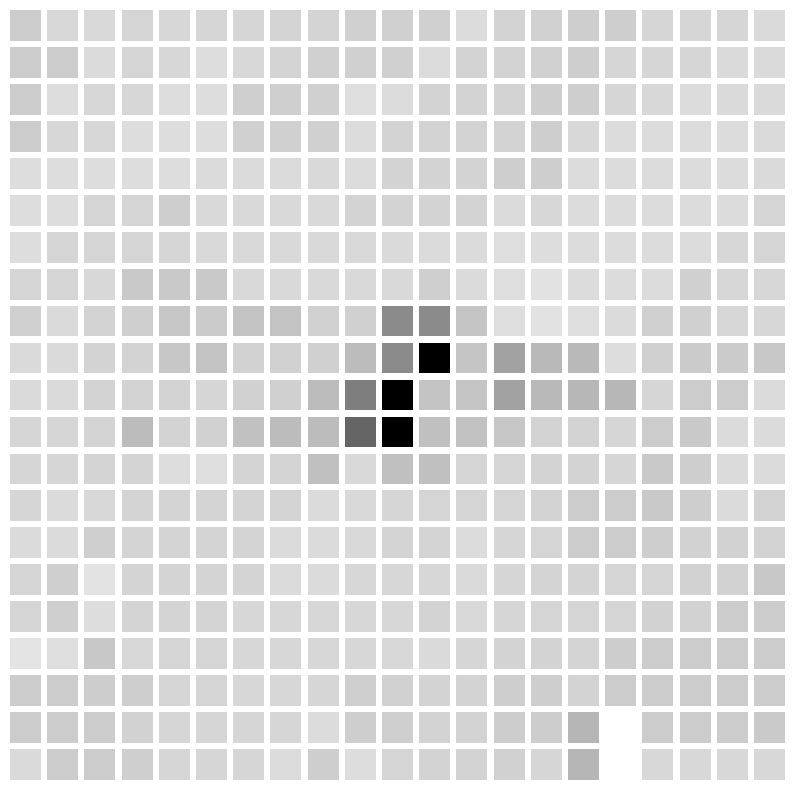

<Figure size 640x480 with 0 Axes>

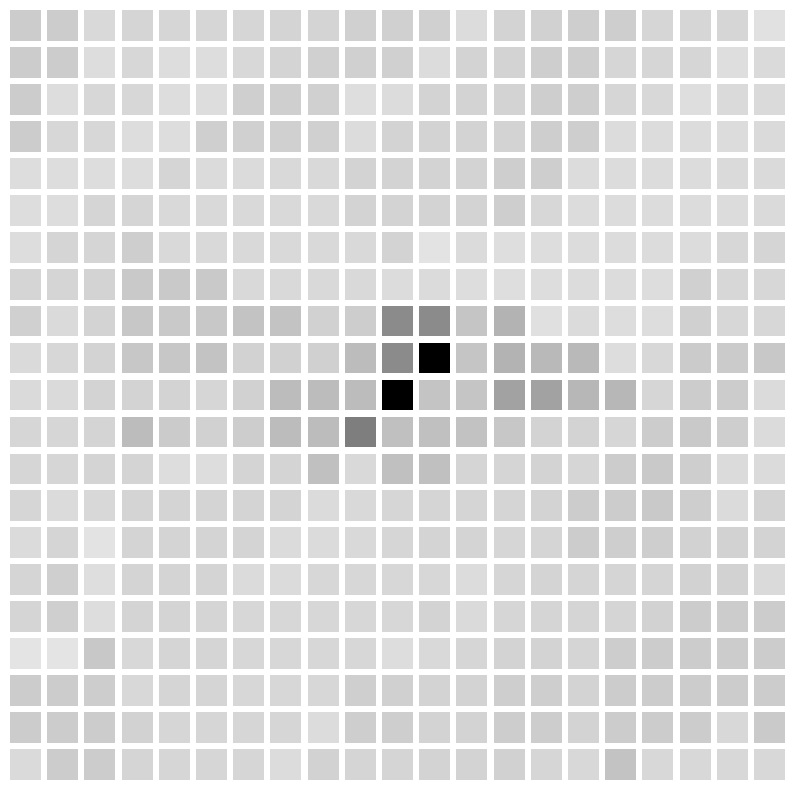

<Figure size 640x480 with 0 Axes>

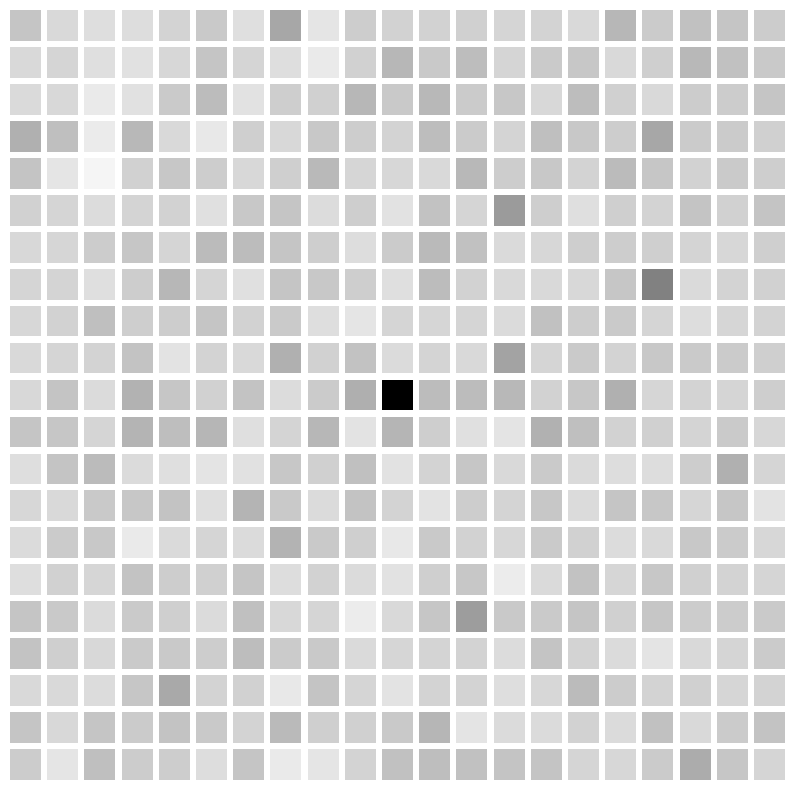

<Figure size 640x480 with 0 Axes>

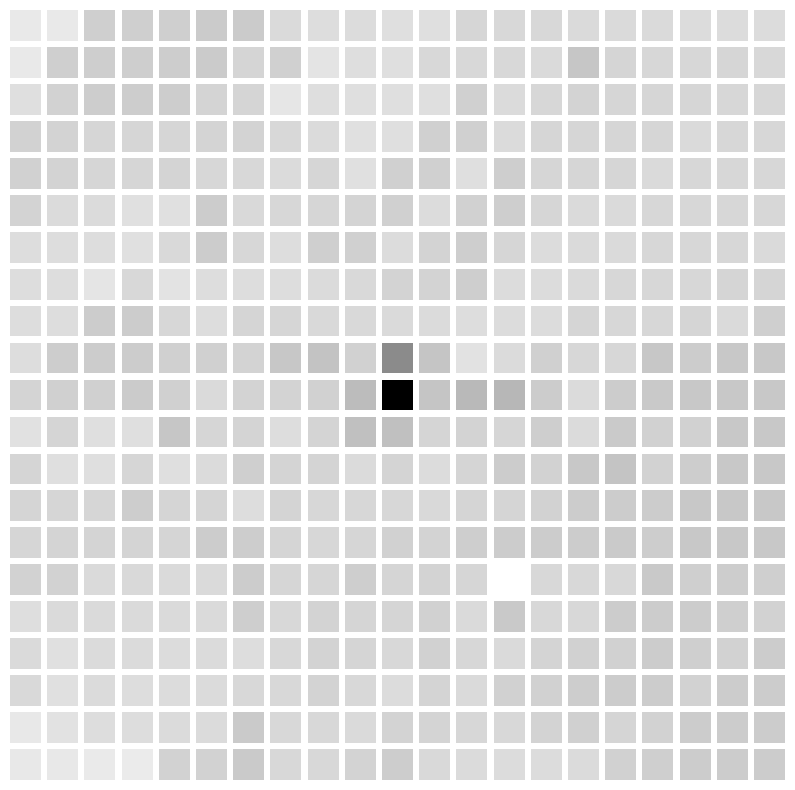

<Figure size 640x480 with 0 Axes>

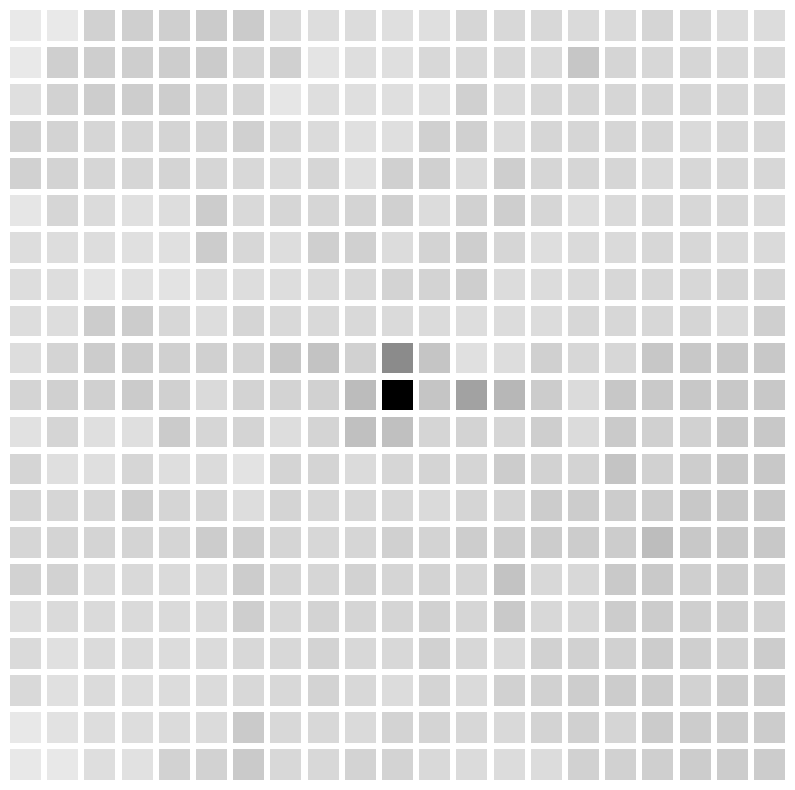

<Figure size 640x480 with 0 Axes>

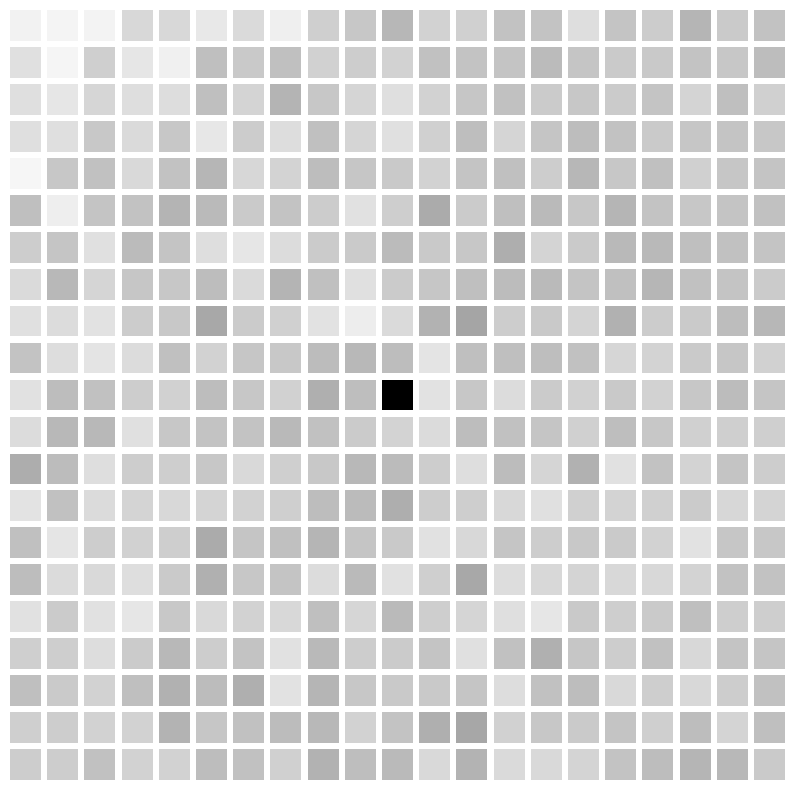

<Figure size 640x480 with 0 Axes>

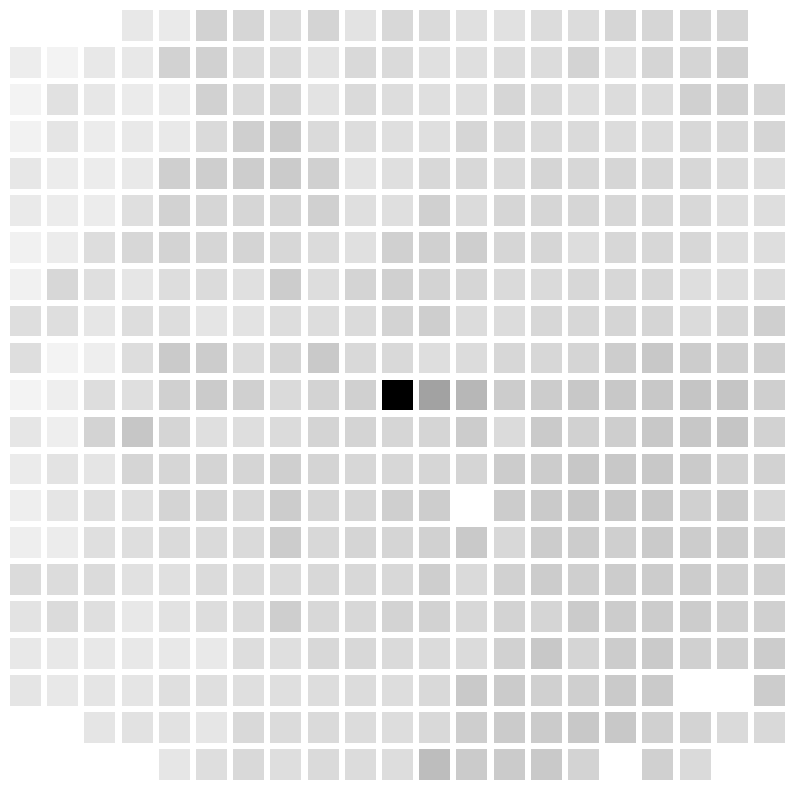

<Figure size 640x480 with 0 Axes>

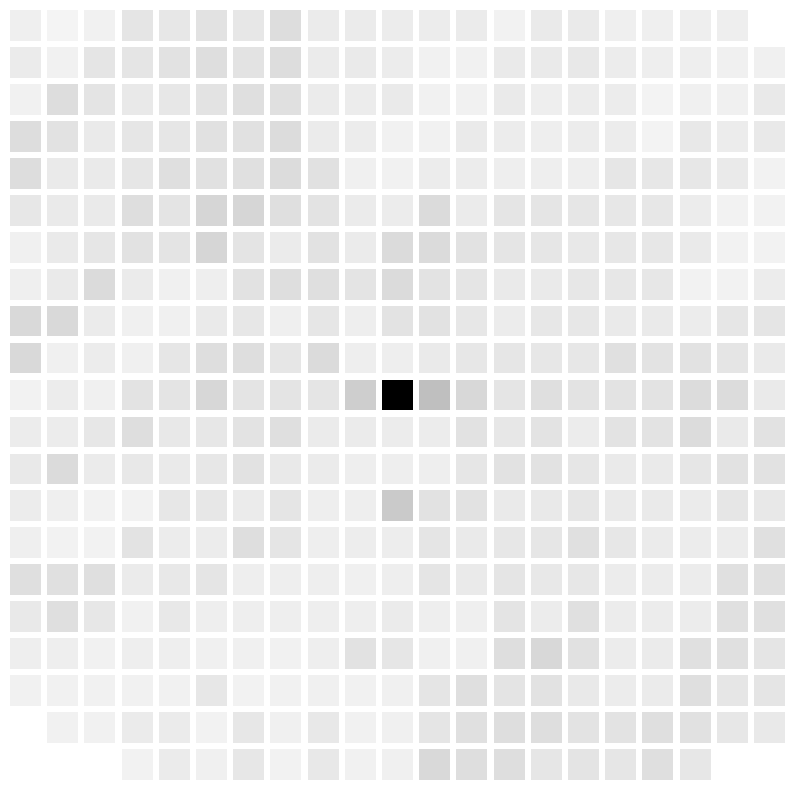

<Figure size 640x480 with 0 Axes>

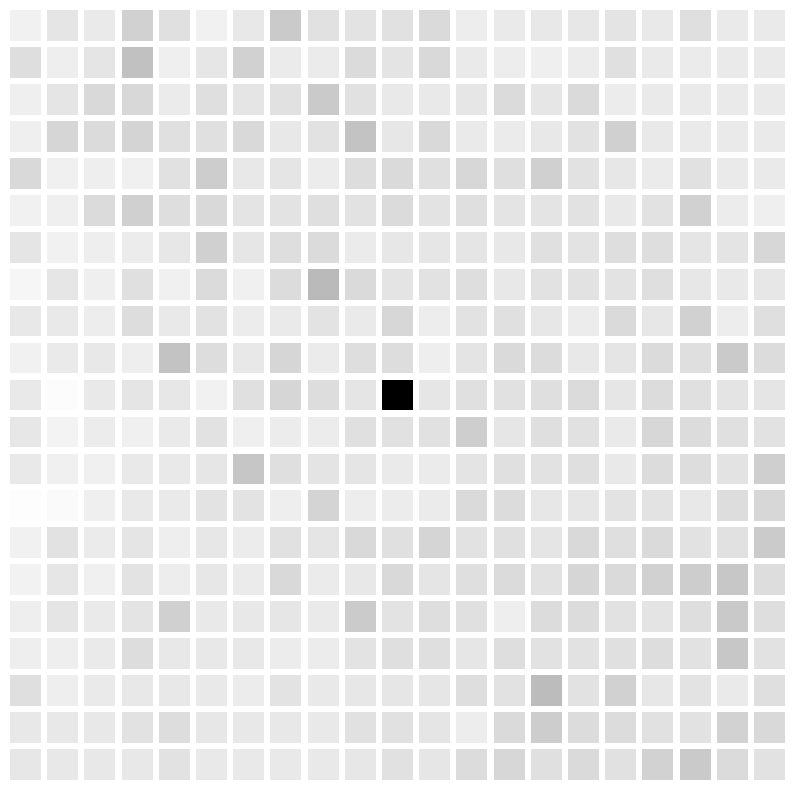

<Figure size 640x480 with 0 Axes>

In [ ]:
for exp_num in range(9):
    freq_df = pd.read_csv(f"{save_folder_path}/csv_folder/{mol_fname}_{exp_num}.csv", index_col=0)
    freq_df = freq_df.where(pd.notnull(freq_df), None)
    plot_freq_mols_with_color(freq_df, save_name=f"{save_folder_path}/color_plot/{mol_fname}_{exp_num}_color.png")

In [ ]:
# TODO : modify the code for successfully decoding the decoded molecule from the model using selfies
# TODO : implement some code for representing latnet space with t-sne